# Modelo de aprendizaje estadístico para clasificar imágenes de sujetos con gafas
---


##### Carlos Mario Calle González
##### Catherine Andrea Córdoba Espinosa
##### Allison Piedrahita García
##### Santiago Ramírez Zapata
##### Jhonier Santiago Serna Cardona

19/08/2021


### **Objetivo** 
<div style="text-align: justify;width:100%;margin: 0 auto"> 
Construir y validar un modelo de aprendizaje estadístico para clasificar imágenes de sujetos con gafas de un conjunto de datos.
</div>
    
### **Planteamiento del problema**
<div style="text-align: justify;width:100%;margin: 0 auto"> 
Se cuenta con una base de datos de 640 imágenes en blanco y negro, en las cuales se pueden observar fotografías de 20 personas desde diferentes ángulos como:
</div>

*   ***Frontal:*** la posición de la persona es recta y mirando directamente al lente de la cámara.
*   ***Lateral izquierdo:*** la posición de la persona es el perfil izquierdo, es decir, la persona se encuentra mirando hacia el lado izquierdo tomando como referencia la posición de la cámara. 
*   ***Lateral derecho:*** la posición de la persona es el perfil derecho, es decir, la persona se encuentra mirando hacia el lado derecho tomando como referencia la posición de la cámara. 
*   ***Frontal superior:*** la posición de la persona es recta pero se encuentra mirando hacia arriba respecto a la posición de la cámara. 

<div style="text-align: justify;width:100%;margin: 0 auto"> 
Adicionalmente, se realizan variaciones para cada persona y para cada una de las posiciones, teniendo en cuenta cuatro expresiones faciales: feliz, triste, enojado y neutral. Asimismo, se toman fotografías para cada variación con gafas y sin gafas. Finalmente, se obtienen combinaciones como:
</div>

*   Mitchell, en posición frontal con expresión facial de enojo y con gafas (mitchell_straight_angry_sunglasses).
*   Danieln, en posición lateral izquierdo con expresión facial neutra y sin gafas (danieln_left_neutral_open)

<div style="text-align: justify;width:100%;margin: 0 auto"> 
Por otra parte, se evidencia que no todas las personas tienen las 32 fotografías de la combinación de las variaciones, hay personas que poseen mínimamente 28 imágenes, esto es debido a problemas en la adquisición de las fotografías con la cámara empleada. Además, se cuentan con tres tipos de resoluciones diferentes: alta, media y baja. Para este caso, se seleccionaron las imágenes con resolución alta (128 columnas x 120 filas). 
<br>
    
El propósito que se tiene con la base de datos es crear un modelo de aprendizaje estadístico que permita clasificar las imágenes en:
</div>

**1.**   ***Personas con gafas***
<br>
**2.**   ***Personas sin gafas***

### **Desarrollo del problema** 
Se inicia el desarrollo del promedio por medio de la importación de las librerias a utilizar:

In [ ]:
#Librerias
import zipfile
import os
import cv2 as cv
import numpy as np
import glob
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

#### **Lectura de datos**

Se cargan las imágenes contenidas en el repositorio de github al entorno de Colab.

In [ ]:
%%capture
 #Link del repositorio de github
!wget --no-check-certificate \
    "https://github.com/jhoniers011/TrabajoTAE3/archive/refs/heads/main.zip" \
    -O "/tmp/imagenes.zip"


zip_ref = zipfile.ZipFile('/tmp/imagenes.zip', 'r') #Abre el archivo.zip en modo lectura
zip_ref.extractall('/tmp') #Extrae los archivos en la carpeta /tmp
zip_ref.close()

In [ ]:
files = glob.glob('/tmp/TrabajoTAE3-main/Imagenes/**/*.pgm',recursive=True) #Se obtienen todas las url de las imágenes.

#### **Lectura de imágenes**

In [ ]:
imagenes = [cv.imread(imagen,-1) for imagen in files] #Se cargan las imágenes y se guardan en una lista

#### **Exploración de la base de datos**

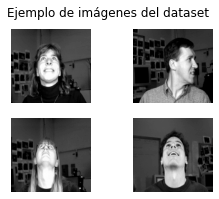

In [ ]:
#Imprimir ejemplos de imágenes del dataset
fig = plt.figure(figsize=(4, 3))
fig.suptitle("Ejemplo de imágenes del dataset")
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(imagenes[100],cmap = "gray")
plt.axis('off')

fig.add_subplot(rows, columns, 2)
plt.imshow(imagenes[150],cmap = "gray")
plt.axis('off')
  

fig.add_subplot(rows, columns, 3)
plt.imshow(imagenes[201],cmap = "gray")
plt.axis('off')

fig.add_subplot(rows, columns, 4)
plt.imshow(imagenes[250],cmap = "gray")
plt.axis('off')

plt.show()

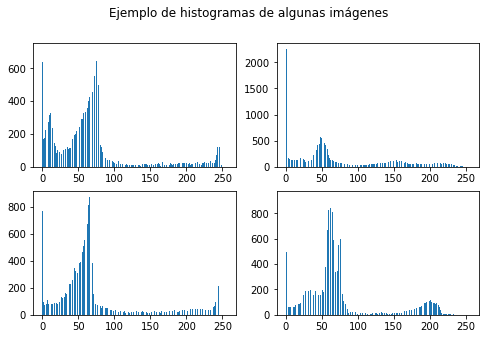

In [ ]:
#Mostrando histogramas
fig = plt.figure(figsize=(8, 5))
fig.suptitle("Ejemplo de histogramas de algunas imágenes")
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.hist(imagenes[100].ravel(),256,[0,256])

fig.add_subplot(rows, columns, 2)
plt.hist(imagenes[150].ravel(),256,[0,256])

fig.add_subplot(rows, columns, 3)
plt.hist(imagenes[201].ravel(),256,[0,256])

fig.add_subplot(rows, columns, 4)
plt.hist(imagenes[250].ravel(),256,[0,256])

plt.show()

<div style="text-align: justify;width:100%;margin: 0 auto">
En una imagen los pixeles con valor de 0 son aquellos considerados como color negro, mientras que los pixeles con valor de 255 pertenecen al color blanco. En este caso, se evidencia entonces que en un valor aproximadamente de 100 se da la división entre aquellos pixeles más oscuros y los más claros, lo cual permitiría hacer una segmentación de las imágenes ya que los valores más oscuros de la base de datos de las fotografías son el fondo y las gafas, mientras que los valores claros estarían en las pieles de las personas. 
</div>

### **Procesamiento de imágenes**
#### **Segmentación de las imágenes**
<div style="text-align: justify;width:100%;margin: 0 auto">
Se aplica la tecnica de umbral, donde dado un valor limite, los valores menores se cambian a 0 y los mayores a 255, por lo que queda una imagen binarizada. Útil para resaltar caracteristicas de las imágenes.
En este caso, como las imágenes se han tomado en ambientes controlados (mismo fondo, misma iluminación, las gafas son las mismas,etc) se aplica la umbralización con el objetivo de eliminar la mayoría del fondo, con el propósito de resaltar las gafas. Se utilizó un valor de 100 como umbral según la forma evidenciada en los histogramas.
</div>

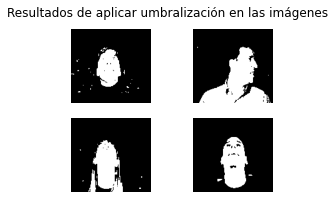

In [ ]:
#Umbralización de las imagenes
threshold_images = []
for imagen in imagenes:
  T,sal = cv.threshold(imagen,100,255,cv.THRESH_BINARY)
  threshold_images.append(sal)


#Mostrando ejemplos de umbralización de las imágenes
fig = plt.figure(figsize=(4, 3))
fig.suptitle("Resultados de aplicar umbralización en las imágenes")
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(threshold_images[100],cmap = "gray")
plt.axis('off')

fig.add_subplot(rows, columns, 2)
plt.imshow(threshold_images[150],cmap = "gray")
plt.axis('off')
  

fig.add_subplot(rows, columns, 3)
plt.imshow(threshold_images[201],cmap = "gray")
plt.axis('off')

fig.add_subplot(rows, columns, 4)
plt.imshow(threshold_images[250],cmap = "gray")
plt.axis('off')

plt.show()

<div style="text-align: justify;width:100%;margin: 0 auto">
Después de realizar la umbralización, es posible evidenciar que en las fotografías de las personas con gafas, éstas quedan perfectamente identificadas en contraste con la piel de las personas, mientras que en el caso en que no tienen gafas, no quedan resaltadas características importantes más que los elementos del rostro, tales como ojos.
</div>

#### **Obteniendo las etiquetas de las imágenes**

Se obtienen de los nombres de las imágenes la respectiva información para saber si tiene o no tiene gafas.

In [ ]:
labels = []
for image in files:
  aux = image.split("_")[3]
  labels.append(aux[:-4])

labels = np.array(labels)

Debido a que algunos clasificadores no reciben las clases o etiquetas en forma de texto, se binarizan quedando de la siguiente manera:  
* **0:** imagen de persona que **NO** tiene gafas  
* **1:** imagen de persona que **SI** tiene gafas

In [ ]:
#Binarizando las etiquetas
lb = preprocessing.LabelBinarizer()
labels = lb.fit_transform(labels)

### **Desarrollo del clasificador**

#### **Modelo 1: máquinas de soporte vectorial**
<div style="text-align: justify;width:100%;margin: 0 auto">
Se utilizará como clasificador una máquina de vectores de soporte, esta técnica utiliza un hiperplano para separar las muestras de datos a dos o más espacios lo más amplio posibles (depende de las clases). Las observaciones que queden más cercanas al hiperplano se les llama vectores soporte y son los que definen el clasificador obtenido.
Tiene un hiperparámetro C que controla la penalización de errores de clasificación, entre más cerca de cero, menos se penalizan.
</div>

<br>

<div style="text-align: justify;width:100%;margin: 0 auto">
Esta separación no solo se puede hacer de forma lineal, si no que se puede utilizar funciones Kernel (polinómico, radial,etc) para obtener un espacio de mayor dimensionalidad. Por lo que tienen un parámetro gamma que ayuda a controlar la flexibilidad del modelo. 
</div>

In [ ]:
#Aplanamiento de imagenes
flatten_images = []
for image in threshold_images:
  flatten_images.append(image.flatten())

#### **Entrenamiento del modelo SVM**
Se dividen los datos en entrenamiento y validación, en este caso, por elección de los autores, se selecciona un conjunto de entrenamiento del 80% de los datos que se tienen, lo que equivale a 499 imágenes.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(flatten_images,
                                                 labels.ravel(),
                                                 train_size = 0.8,
                                                 random_state = 1234,
                                                 shuffle = True
                                                 )

Se utilizará validación cruzada para obtener los mejores parámetros de C, Gamma y kernel para el modelo basado en máquinas de vectores de soporte.

In [ ]:
param_grid = {'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['linear','rbf','poly']}

svc = SVC(probability=True)
model = GridSearchCV(svc,param_grid)

In [ ]:
#Buscamos los mejores parámetros
model.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Los mejores parámetros encontrados en el modelo son:

In [ ]:
print("C:",model.best_params_["C"])
print("Gamma:",model.best_params_["gamma"])
print("Kernel:",model.best_params_["kernel"])

C: 0.1
Gamma: 0.0001
Kernel: linear


### Visualizando el desempeño en entrenamiento

In [ ]:
pred_training = model.predict(X_train)
Classification_report_svm_training = classification_report(y_train,pred_training,labels=[0,1],target_names=["No tiene gafas","Tiene gafas"],output_dict=True)
Dataframe_score = pd.DataFrame(Classification_report_svm_training).T
Dataframe_score.round(2)

,precision,recall,f1-score,support
No tiene gafas,1.0,1.0,1.0,250.0
Tiene gafas,1.0,1.0,1.0,249.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,499.0
weighted avg,1.0,1.0,1.0,499.0


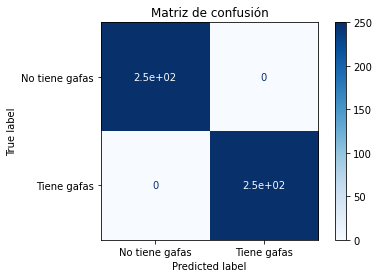

In [ ]:
#Matriz de confusion
matriz_conf_svm = plot_confusion_matrix(model,X_train,y_train,display_labels=["No tiene gafas","Tiene gafas"],cmap=plt.cm.Blues)
matriz_conf_svm.ax_.set_title("Matriz de confusión")
plt.show()


#### **Visualizando desempeño del modelo en validación**

In [ ]:
pred = model.predict(X_test)
Classification_report_svm = classification_report(y_test,pred,labels=[0,1],target_names=["No tiene gafas","Tiene gafas"],output_dict=True)
Dataframe_score = pd.DataFrame(Classification_report_svm).T
Dataframe_score.round(2)

,precision,recall,f1-score,support
No tiene gafas,0.98,0.89,0.93,63.00
Tiene gafas,0.90,0.98,0.94,62.00
accuracy,0.94,0.94,0.94,0.94
macro avg,0.94,0.94,0.94,125.00
weighted avg,0.94,0.94,0.94,125.00


Teniendo en cuenta las medidas de precisión, recall, f1-score se obtienen las diferentes métricas de desempeño. Como se evidencia en la tabla anterior, el porcentaje de casos en los que el modelo acierta es del 94%, lo cual demuestra que el modelo creado por medio de la técnica de máquinas de soporte vectorial es bueno. Adicionalmente, se evidencia que las demás métricas de desempeño se encuentran por encima del 94%

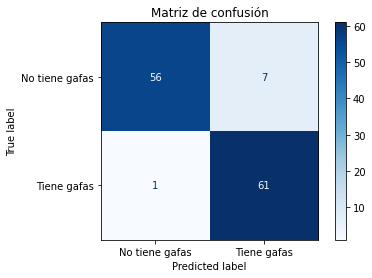

In [ ]:
matriz_conf_svm = plot_confusion_matrix(model,X_test,y_test,display_labels=["No tiene gafas","Tiene gafas"],cmap=plt.cm.Blues)
matriz_conf_svm.ax_.set_title("Matriz de confusión")
plt.show()

En la matriz de confusión, se observa que al aplicar el modelo al conjunto de datos de validación, que corresponde al 20% de la base de datos, es decir, a 125 datos, la mayoría de los resultados que se obtienen son verdaderos positivos, es decir, que el modelo clasifica a las personas que si tienen gafas como personas que si tienen gafas en una frecuencia de 61 datos, por otro lado, siguen los verdaderos negativos, lo que equivale a decir que el modelo clasifica a las personas que no tienen gafas como personas que no tienen gafas, con una frecuencia de 56 datos. De estos resultados, se evidencia que el modelo tiene una frecuencia de error de 8 datos, lo cual se esperaba con las métricas de desempeño hechas anteriormente.

#### **Modelo 2: k vecinos más cercanos (KNN)**

Se desarrolla un segundo clasificador utilizando el método de los **k** vecinos más cercanos con ayuda de los conocimientos previos.

In [ ]:
#Se normalizan las imágenes
normalizadas = []
for image in threshold_images:
  normalizadas.append(image/255)

normalizadas = np.array(normalizadas)

#Se dividen los datos en entrenamiento y validación.

X_train, X_test, y_train, y_test = train_test_split(normalizadas,labels.flatten(),random_state = 42,test_size = 0.2)

X_train = np.reshape(X_train,(X_train.shape[0],-1))
X_test = np.reshape(X_test,(X_test.shape[0],-1))

Se busca el mejor valor de **k** para entrenar el modelo, se hace corriendo modelos KNN con valores de **k** desde 1 a 50, y se grafica la tasa de error con referencia al valor **k** respectivo, buscando minimizar la tasa de error.

Text(0, 0.5, 'Error Rate')

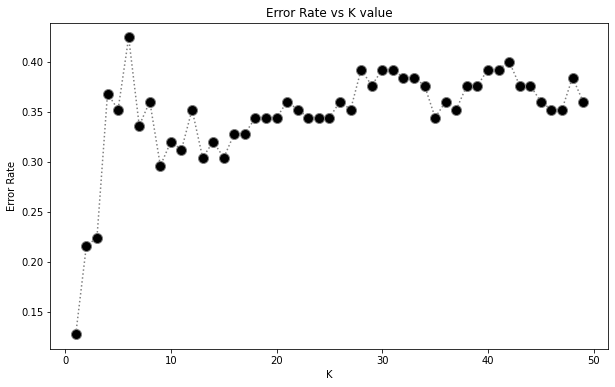

In [ ]:
#Buscando el mejor K
error_rate = []

for k in range(1,50):
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_train,y_train)
  pred_i = neigh.predict(X_test)
  error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,color='gray',linestyle='dotted',marker='o',markerfacecolor = 'black',markersize = 10)
plt.title('Error Rate vs K value')
plt.xlabel('K')
plt.ylabel('Error Rate')

Según la gráfica, el **k** que minimiza el error es k=1 y por lo tanto, se procede con este valor.

In [ ]:
print("Error mínimo: ",round(min(error_rate),2), "en K =",error_rate.index(min(error_rate))+1)

Error mínimo:  0.13 en K = 1


Se entrena el modelo con k=1 y se visualiza el desempeño del modelo.

In [ ]:
#Entrenamieto del modelo
knn_model = KNeighborsClassifier(n_neighbors=1).fit(X_train,y_train)

#### Desempeño del modelo en entrenamiento

In [ ]:
pred_training = knn_model.predict(X_train)
Classification_report_knn = classification_report(y_train,pred_training,labels=[0,1],target_names=["No tiene gafas","Tiene gafas"],output_dict=True)
Dataframe_score_knn = pd.DataFrame(Classification_report_knn).T
Dataframe_score_knn.round(2)

,precision,recall,f1-score,support
No tiene gafas,1.0,1.0,1.0,255.0
Tiene gafas,1.0,1.0,1.0,244.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,499.0
weighted avg,1.0,1.0,1.0,499.0


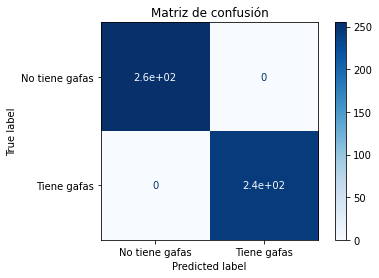

In [ ]:
#Matriz de confusión
matriz_conf_knn = plot_confusion_matrix(knn_model,X_train,y_train,display_labels=["No tiene gafas","Tiene gafas"],cmap=plt.cm.Blues)
matriz_conf_knn.ax_.set_title("Matriz de confusión")
plt.show()

### Desempeño en validación

In [ ]:
#Metricas de desempeño
pred = knn_model.predict(X_test)
Classification_report_knn = classification_report(y_test,pred,labels=[0,1],target_names=["No tiene gafas","Tiene gafas"],output_dict=True)
Dataframe_score_knn = pd.DataFrame(Classification_report_knn).T
Dataframe_score_knn.round(2)

,precision,recall,f1-score,support
No tiene gafas,0.89,0.83,0.86,58.00
Tiene gafas,0.86,0.91,0.88,67.00
accuracy,0.87,0.87,0.87,0.87
macro avg,0.87,0.87,0.87,125.00
weighted avg,0.87,0.87,0.87,125.00


Teniendo en cuenta las medidas de precisión, recall, f1-score se obtienen las diferentes métricas de desempeño. Como se evidencia en la tabla anterior, el porcentaje de casos en los que el modelo acierta es del 87%, lo cual demuestra que el modelo creado por medio de la técnica de KNN es bueno. Adicionalmente, se evidencia que las demás métricas se encuentran por encima del 83%.

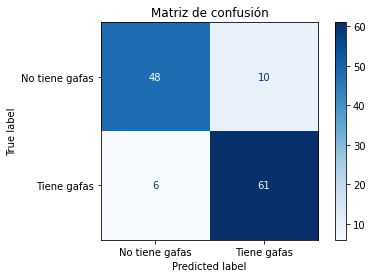

In [ ]:
#Matriz de confusión
matriz_conf_knn = plot_confusion_matrix(knn_model,X_test,y_test,display_labels=["No tiene gafas","Tiene gafas"],cmap=plt.cm.Blues)
matriz_conf_knn.ax_.set_title("Matriz de confusión")
plt.show()

En la matriz de confusión, se observa que al aplicar el modelo al conjunto de datos de validación, que corresponde al 20% de la base de datos, es decir, a 125 datos, la mayoría de los resultados que se obtienen son verdaderos positivos, es decir, que el modelo clasifica a las personas que si tienen gafas como personas que si tienen gafas en una frecuencia de 61 datos, por otro lado, siguen los verdaderos negativos, lo que equivale a decir que el modelo clasifica a las personas que no tienen gafas como personas que no tienen gafas, con una frecuencia de 48 datos. De estos resultados, se evidencia que el modelo tiene una frecuencia de error de 16 datos, lo cual se esperaba con las métricas de desempeño hechas anteriormente.

### **Conclusiones**
* El modelo de clasificación basado en máquinas de soporte vectorial tuvo muy buenos resultados, esto puede ser porque los datos son linealmente separables debido a que las imágenes fueron realizadas en ambientes controlados, lo que facilita el reconocimiento de características útiles en las imágenes. Además, las máquinas de soporte vectorial son eficaces con datos de alta dimensionalidad, como es este caso.
 
* El modelo de clasificación basado en los k vecinos más cercanos obtuvo buenos resultados teniendo en cuenta que este método puede tener el problema de la maldición de la dimensionalidad, pero debido a la simplicidad de las imágenes, es capaz de diferenciarlas correctamente. El valor del mejor k (k=1) se atribuye a la similaridad que hay con los datos de entrenamiento y validación.

* Teniendo en cuenta los resultados de los dos modelos implementados, se selecciona el clasificador desarrollado por medio de máquinas de soporte vectorial, dado que entre este y KNN se obtiene un 5% menos de error.

* Los resultados en entrenamiento para los dos modelos dan perfecto en todas las métricas, esto podría parecer muy bueno, pero puede significar sobreajuste (overfitting), lo que conlleva a que en datos nuevos que no sean tan parecidos a los de entrenamiento los modelos tengan un rendimiento bajo,  pero en este caso como todos los datos tienen la misma configuración (luz,tipo de gafas, ambiente controlado, colores, etc) es un resultado admisible. 


### **Referencias**
* [1]. M. Hoai Nguyen, J. Pérez y F. De la Torre, "Facial Feature Detection with Optimal Pixel Reduction SVM", IEEE, agosto de 2008.
* [2]. J. Amat Rodrigo. "Máquinas de Vector Soporte (Support Vector Machines, SVMs)". Cienciadedatos. Disponible en: https://www.cienciadedatos.net/documentos/34_maquinas_de_vector_soporte_support_vector_machines [accedido el 16 de agosto de 2021].
* [3]. Anónimo. Clasificación de Imágenes en Python. Disponible en: https://www.aprendemachinelearning.com/clasificacion-de-imag [accedido el 16 de agosto de 2021].
* [4]. "UCI Machine Learning Repository: Center for Machine Learning and Intelligent Systems". CMU Face Images Data Set. Disponible en: https://archive.ics.uci.edu/ml/datasets/CMU+Face+Images [accedido el 16 de agosto de 2021].
* [5]. A. Brand, "How to find the optimal value of K in KNN?", Medium, 2020. Disponible en: https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb. [accedido el 16 de agosto de 2021].
* [6]. C. Gil Martinez, "RPubs - Máquinas de Vector Soporte", Rpubs.com, 2018. Disponible en: https://rpubs.com/Cristina_Gil/SVM. [accedido el 16 de agosto de 2021].
